# TimeSeries Analysis

该部分完成一些初步的相关时间序列分析。

In [1]:
import os
import pandas as pd
import numpy as np

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt
plt.style.use('ggplot') 


# 数据预处理

data = pd.concat([pd.read_csv('./price_data/' + i) for i in os.listdir('./price_data/')])    # 导入数据

clean = lambda x : x.strip()
data['Full_name'] = data['Full_name'].apply(clean)     # 这里做strip是因为刚开始几天收集的略有磨损皮肤的名称最后有空格没去除
data['Time'] = pd.to_datetime(data['Time'])            # 转化时间变量
data.set_index('Time', inplace=True)                   # 调整index
data['OnSale'] = data['OnSale'].str.extract(r'(\d+)')  # 提取在售里面的数字
data['OnSale'] = data['OnSale'].apply(int)
data.head()

,Full_name,Quality,Type,Kind,Exterior,Price,OnSale
Time,,,,,,,
2023-06-10 21:45:00,蝴蝶刀（★） | 屠夫 (略有磨损),隐秘,★,匕首,略有磨损,10165.00,284
2023-06-10 21:45:00,蝴蝶刀（★） | 屠夫 (崭新出厂),隐秘,★,匕首,崭新出厂,12287.50,284
2023-06-10 21:45:00,蝴蝶刀（★） | 屠夫 (久经沙场),隐秘,★,匕首,久经沙场,8650.00,284
2023-06-10 21:45:00,暗影双匕（★） | 噩梦之夜 (略有磨损),隐秘,★,匕首,略有磨损,811.00,12
2023-06-10 21:45:00,暗影双匕（★） | 噩梦之夜 (久经沙场),隐秘,★,匕首,久经沙场,660.89,12


In [2]:
# 获取百分比变化
def GetReturn(SkinName):
    '''
    Get the history return of with the given skin name
    
    Args:
        SkineName: string, the skin name
    Output:
        History return
    '''
    global data
    
    return_ = data[data['Full_name'] == SkinName]['Price'].sort_index().pct_change().rename('Return')
    
    return return_


# 获取市价指数
def GetIndex(kind):
    '''
    Get the Market index by category.
    
    Args:
        kind : string, the market index kind
    Output:
        MarketIndex : pd.series, the history price index of the given kind
    '''
    
    list_ = ['全部', '匕首', '步枪', '手枪', '微型冲锋枪', '手套', '狙击步枪', '霰弹枪', '机枪']
    
    assert kind in ['全部', '匕首', '步枪', '手枪', '微型冲锋枪', '手套', '狙击步枪', '霰弹枪', '机枪'], {
        f'No index exists, feasible indexes\n:{list_}'}
    
    global data

    history = data[(data['Kind'] == kind) & (data['Exterior'] == '略有磨损')][['Price', 'OnSale']]
    cleanData = []
    for time in history.index.unique():
        dropData = history.loc[time].sort_values('Price')
        dropData = dropData.iloc[int(len(dropData) * 0.1) : int(len(dropData) * 0.9), :]
        cleanData.append(dropData)
    cleanData = pd.concat(cleanData)

    def CalculateIndex(price, weight):
        result = 0
        for i in range(len(price)):
            result += price.iloc[i] * weight.iloc[i]

        result = result / weight.sum()

        return result

    HistoryIndex = []
    for time in cleanData.index.unique():
        CrossData = cleanData.loc[time]
        index = CalculateIndex(CrossData['Price'], CrossData['OnSale'])
        oneday = {
            'Time' : time,
            'Index' : index
        }
        HistoryIndex.append(oneday)

    HistoryIndex = pd.DataFrame(HistoryIndex)
    HistoryIndex['Time'] = pd.to_datetime(HistoryIndex['Time'])
    HistoryIndex.set_index('Time', inplace=True)
    return HistoryIndex.sort_index()

首先取出一个皮肤看一下历史波动，这里选择的是AK47可燃冰

<Axes: xlabel='Time'>

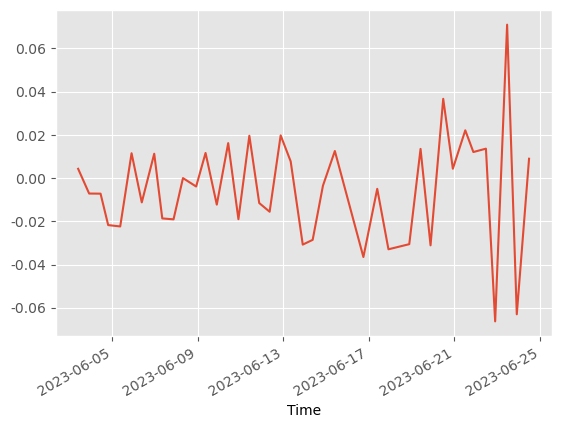

In [3]:
AK47 = GetReturn('AK-47 | 可燃冰 (略有磨损)')
AK47.plot()

数据量上还是较少，价格波动率高点出现在最近一两天。周期性还没有显现。然后再来看一下自相关性：

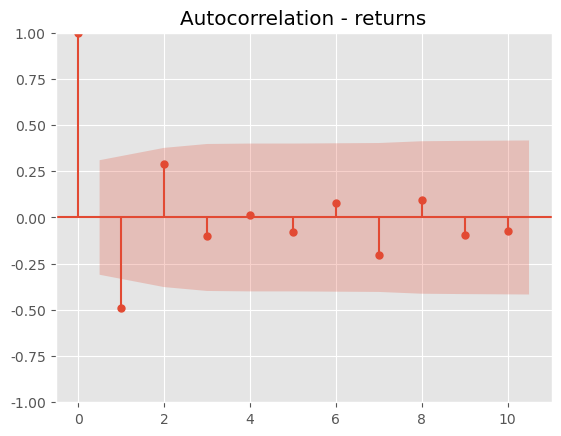

In [4]:
plot_acf(AK47.dropna(), lags = 10, title='Autocorrelation - returns');

一期滞后出现了显著的自相关性，由于数据一天收集两次，说明连续两个半天内价格变动方向大多相反，有些均值回归的味道。这里我想再画一下散点图观察一下

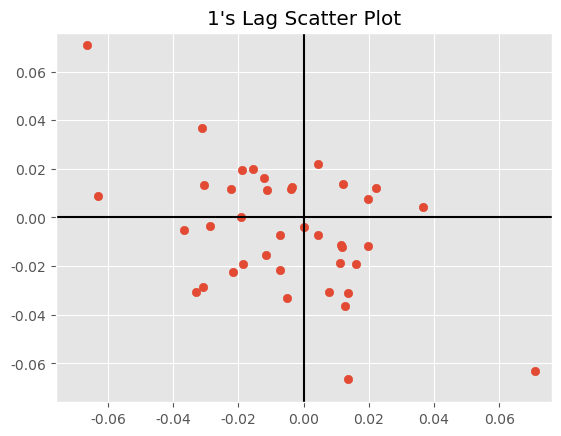

In [5]:
def LagScaterPlot(timeseries, n=1):
    
    lag = timeseries.shift(n)
    maxValue = float(timeseries.dropna().abs().max())
    plt.title(f'{n}\'s Lag Scatter Plot')
    plt.ylim(-maxValue - 0.005, maxValue + 0.005)
    plt.xlim(-maxValue - 0.005, maxValue + 0.005)
    plt.scatter(lag, timeseries)
    plt.axhline(0, color='black')
    plt.axvline(0, color='black')
    
    return None

LagScaterPlot(AK47)

有两个数据点较为偏离，移除后查看

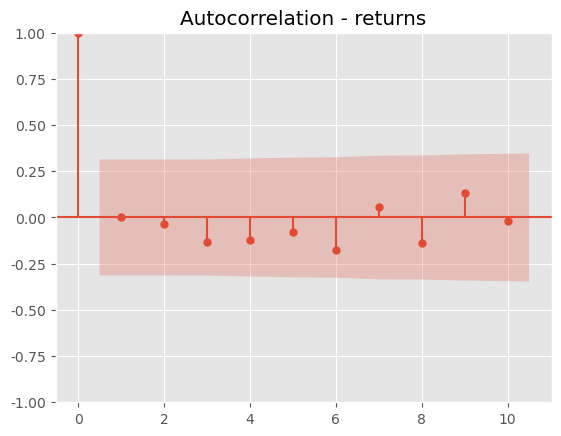

In [6]:
new = AK47[AK47 < AK47.max()].dropna()
plot_acf(new, lags = 10, title='Autocorrelation - returns');

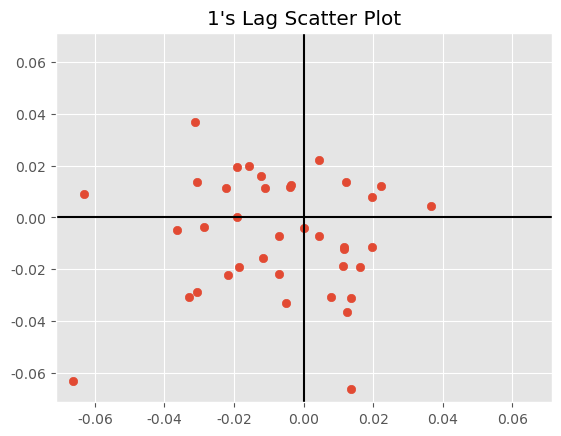

In [7]:
LagScaterPlot(new)

自相关性消失,再来尝试一下指数

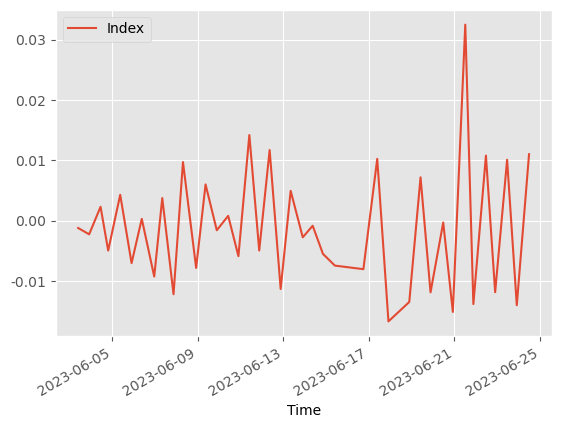

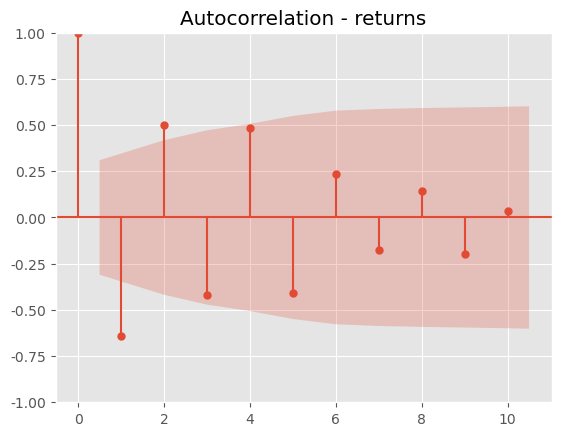

In [8]:
index = GetIndex('步枪')
indexReturn = index.pct_change().dropna()
indexReturn.plot()
plot_acf(indexReturn, lags = 10, title='Autocorrelation - returns');

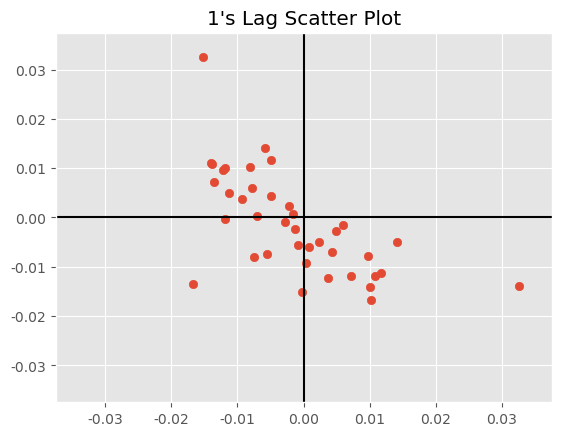

In [9]:
LagScaterPlot(indexReturn)

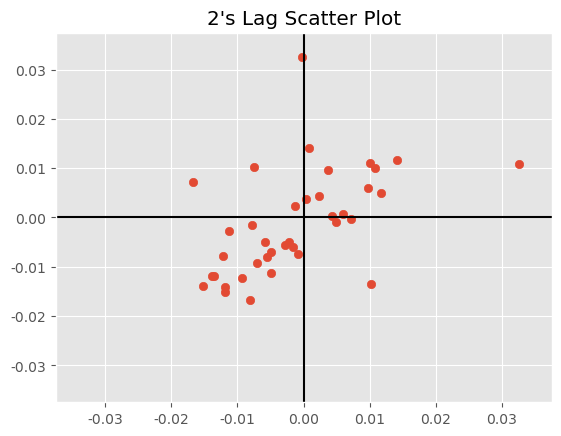

In [10]:
LagScaterPlot(indexReturn, n=2)

虽然没有去除极值点，但仍能从步枪的滞后散点图中看出极为明显的一阶滞后负相关和二阶正相关。